##**Sensing, Perception, and Actuation Course**

**Primary Instructor: Ilya Afanasyev**

**TA: Karam Almaghout**

**Lab 6, 8 Dec. 2022**

## Stereo Vision

In [1]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

ERROR: Could not find a version that satisfies the requirement opencv-python==3.4.2.16 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66)
ERROR: No matching distribution found for opencv-python==3.4.2.16
ERROR: Could not find a version that satisfies the requirement opencv-contrib-python==3.4.2.16 (from versions: 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66)
ERROR: No matching distribution found for opencv-contrib-python==3.4.2.16


In [3]:
!wget "https://www.dropbox.com/s/8p3soizjsehk20c/stereoVision.zip?dl=0" -O stereoVision.zip
!unzip stereoVision.zip 

--2022-12-08 08:04:50--  https://www.dropbox.com/s/8p3soizjsehk20c/stereoVision.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8p3soizjsehk20c/stereoVision.zip [following]
--2022-12-08 08:04:50--  https://www.dropbox.com/s/raw/8p3soizjsehk20c/stereoVision.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca4eb3b87aadcd83431a08abcd8.dl.dropboxusercontent.com/cd/0/inline/ByPpXVDWsO9sqbvQy9_FzPdEQJvmi84H7yL4OL3Y9B3PGwwj-14XWnHuT4z5o-cXWMIFxu7Vdd8e0u7AwyebR5VQ355QqyDFgyIXaJGg4YfqLyB-y-lPKC73hUh7CBec9FR7ptzhkyaiTIHfm0xh9gWvdpRSVRm4r_ynMzu02PmZ_w/file# [following]
--2022-12-08 08:04:51--  https://uca4eb3b87aadcd83431a08abcd8.dl.dropboxusercontent.com/cd/0/inline/ByPpXVDWsO9sqbvQy9_FzPdEQJvmi84H7yL4OL3Y9B3PGwwj-14XWnHuT4z5o-c

In [16]:
def showInRow(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

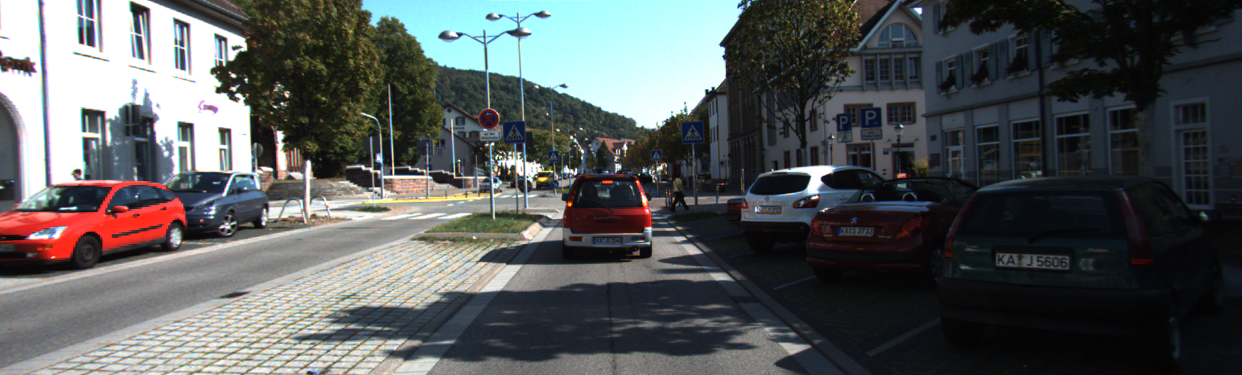

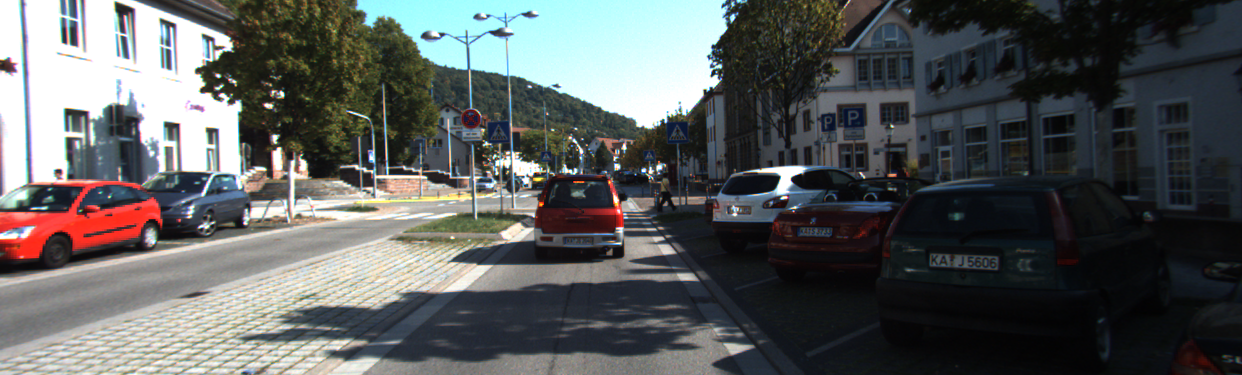

In [52]:
############################### 1- use sift to detect key points ##############################
import numpy as np 
import cv2 
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# Load the left and right images 
# in gray scale 
left_img_path = "/content/stereoVision/left/000002.png"
right_img_path = "/content/stereoVision/right/000002.png"
imgLeft = cv2.imread(left_img_path) 
imgRight = cv2.imread(right_img_path) 
cv2_imshow(imgLeft)
cv2_imshow(imgRight)
# Detect the SIFT key points and 
# compute the descriptors for the 
# two images 
sift = cv2.xfeatures2d.SIFT_create() 
keyPointsLeft, descriptorsLeft = sift.detectAndCompute(imgLeft, None) 

keyPointsRight, descriptorsRight = sift.detectAndCompute(imgRight, None) 

# Create FLANN matcher object 
FLANN_INDEX_KDTREE = 0
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, 
				trees=5) 
searchParams = dict(checks=50) 
flann = cv2.FlannBasedMatcher(indexParams, 
							searchParams) 
#matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
matches = flann.knnMatch(descriptorsLeft, descriptorsRight, k=2)
# Apply ratio test 
goodMatches = [] 
ptsLeft = [] 
ptsRight = [] 


for m,n in matches:
  if m.distance < 0.8* n.distance :
        goodMatches.append(m)
        ptsRight.append(keyPointsRight[m.trainIdx].pt)
        ptsLeft.append(keyPointsLeft[m.queryIdx].pt)


In [69]:
############################### 2- get fundamental matrix and use ravel to rearrange points ##############################
ptsLeft = np.float32(ptsLeft) 
ptsRight = np.float32(ptsRight) 

F, mask = cv2.findFundamentalMat(ptsLeft,ptsRight, cv2.FM_8POINT) 
print(F)
# We select only inlier points 
ptsLeft = ptsLeft[mask.ravel() == 1] 
ptsRight = ptsRight[mask.ravel() == 1] 


[[-1.47008679e-07 -1.78387475e-04  6.89862982e-02]
 [ 1.72663468e-04 -2.05584009e-05  4.37687759e+00]
 [-7.03384569e-02 -4.36882208e+00  1.00000000e+00]]


In [64]:
############################### 3- function to draw lines and points on images ##############################
def drawlines(img1, img2, lines, pts1, pts2): 
	img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) 
	img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
	r, c = img1.shape 
	img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR) 
	img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR) 
	
	for r, pt1, pt2 in zip(lines, pts1, pts2): 
		
		color = tuple(np.random.randint(0, 255, 3).tolist()) 
		
		x0, y0 = map(int, [0, -r[2] / r[1] ]) 
		x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ]) 
		
		img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1) 
		img1 = cv2.circle(img1, (int(pt1[0]), int(pt1[1])), 5, color, -1) 
		img2 = cv2.circle(img2, (int(pt2[0]), int(pt2[1])), 5, color, -1) 
	return img1, img2 


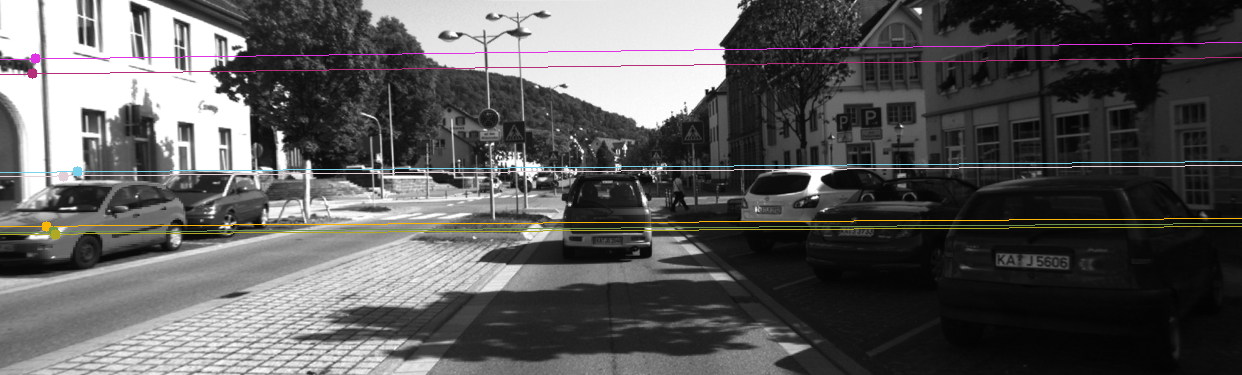

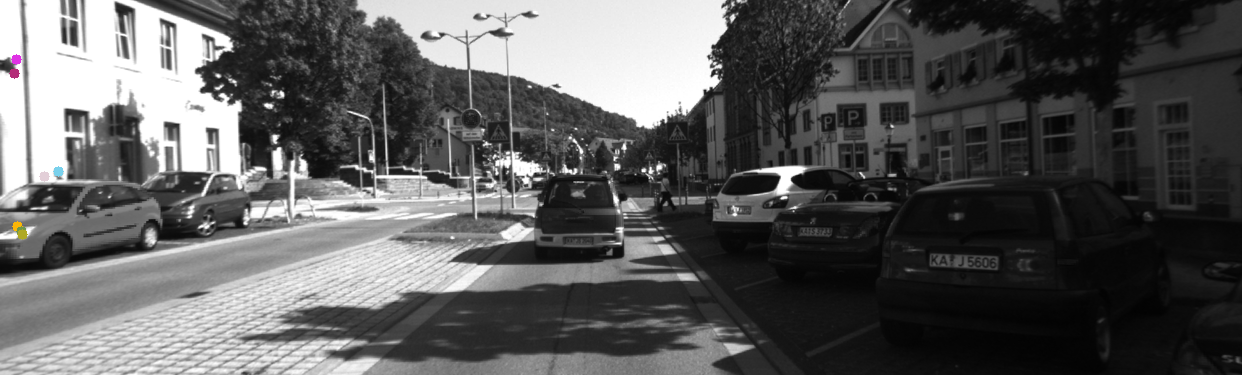

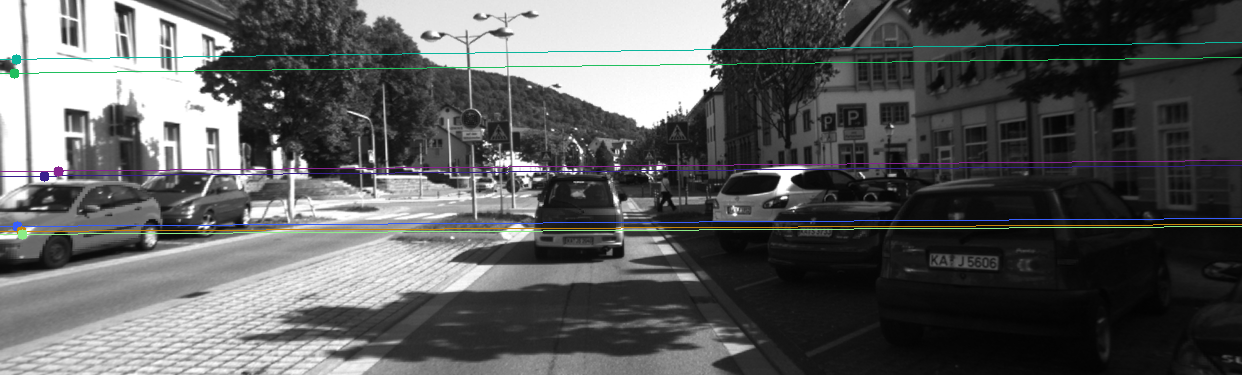

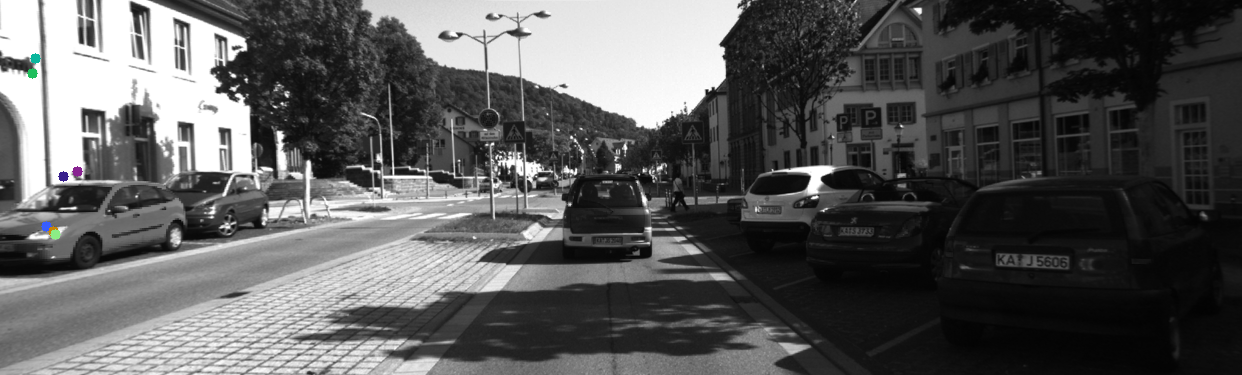

In [65]:
############################### 4- get epilines and draw on images crrospondece points ##############

ptsRight_8=ptsRight[:8]
ptsLeft_8=ptsLeft[:8]

# # Find epilines corresponding to points in right image (second image) and
# # drawing its lines on left image
linesLeft = cv2.computeCorrespondEpilines(ptsRight_8.reshape(-1, 1, 2), 2, F) 
linesLeft = linesLeft.reshape(-1, 3) 
img5, img6 = drawlines(imgLeft, imgRight, linesLeft, ptsLeft_8, ptsRight_8) 

# Find epilines corresponding to points in left image (first image) and 
# drawing its lines on right image 
linesRight = cv2.computeCorrespondEpilines(ptsLeft_8.reshape(-1, 1, 2), 1, F) 
linesRight = linesRight.reshape(-1, 3) 
img3, img4 = drawlines(imgRight, imgLeft, linesRight, ptsRight_8, ptsLeft_8) 

cv2_imshow(img5)
cv2_imshow(img6)
cv2_imshow(img3)
cv2_imshow(img4)

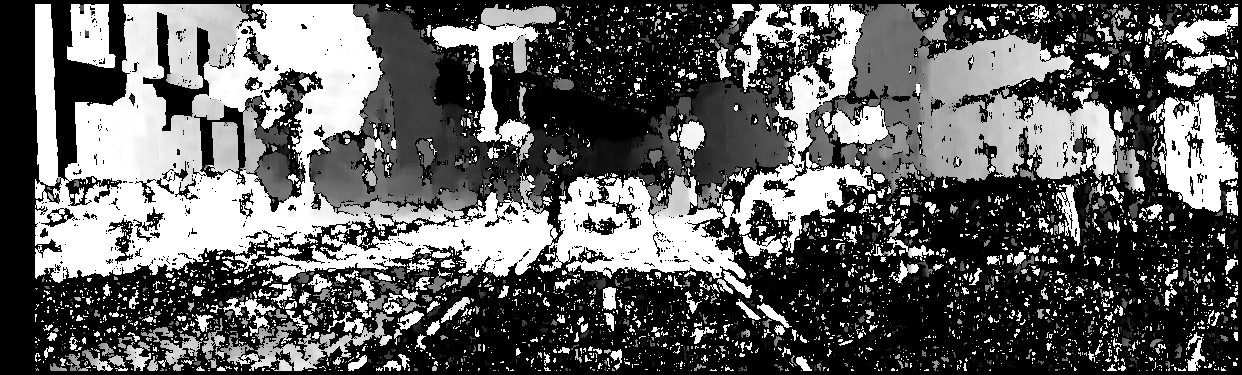

In [66]:
############################### 5- draw dispiratiy map ##############
stereo = cv2.StereoBM_create(numDisparities=32, blockSize=9)
img1 = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2GRAY) 
img2 = cv2.cvtColor(imgRight, cv2.COLOR_BGR2GRAY)
disparity = stereo.compute(img1, img2)
cv2_imshow(disparity)

In [ ]:
# cv.reprojectImageTo3D(	)


In [ ]:
############################### finish #######################################